In [2]:
import sys
sys.path.insert(0, 'C:/Users/14432/OneDrive/Research/Projects/A549_144hr/src/4_wk_trajectory/')
sys.path.insert(1, 'C:/Users/14432/OneDrive/Research/Projects/A549_144hr/src/memes/')

import warnings
warnings.filterwarnings("ignore")

import numpy as np
from skimage import measure
from skimage.segmentation import find_boundaries
from skimage.morphology import opening,closing
from skimage.io import imread
import matplotlib
from matplotlib import pyplot as plt
import os
from os import listdir
import pandas as pd
from scipy.stats import kde
import seaborn as sns
import copy
from math import exp,log
import pickle
import scipy.ndimage as ndimage
import scipy.interpolate.fitpack as fitpack
from sklearn import manifold,decomposition,random_projection,cluster,metrics,preprocessing,mixture,model_selection
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import scipy.io as sio

from mpl_toolkits.mplot3d import Axes3D

# from nolitsa.dimension import afn
# from nolitsa.utils import reconstruct
import glob

from scipy import signal
from scipy.signal import medfilt

from statsmodels.tsa.ar_model import AR

from tslearn.utils import to_time_series,to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans,KShape,GlobalAlignmentKernelKMeans,silhouette_score
from tslearn.metrics import dtw_path,dtw_subsequence_path,cdist_gak,cdist_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter,euclidean_barycenter

from skimage.measure import label,regionprops
from traj_scale import sp_traj_scaling
from matplotlib import animation


In [6]:
# dir_path='/home/zoro/Desktop/experiment_data/2019-03-22_a549_tgf4ng_2d/'
# main_path='/home/zoro/Desktop/experiment_data/2019-03-22_a549_tgf4ng_2d/result_without_bgcorr/'

main_path='C:/Users/14432/OneDrive/Research/Projects/A549_144hr/data/'
out_path=main_path+'out/11-2-21_mt_20E-3_lt_35E-2/'

with open (main_path+'morph_pc_scaler','rb') as fp:
    morph_pc_scaler=pickle.load(fp,encoding='iso-8859-1')
    
with open (main_path+'vim_pc_scaler','rb') as fp:
    vim_pc_scaler=pickle.load(fp,encoding='iso-8859-1')

with open (main_path+'label_spread_4d','rb') as fp:
    ls=pickle.load(fp,encoding='iso-8859-1')
    
result_path=main_path+'rc_result/'
sct_path=out_path+'sct/'

# input_path=dir_path+'img/'
# fluor_input_path=dir_path+'vimentin/'

# output_path=dir_path+'output/'
# cells_path=dir_path+'fluor_cells/'


In [7]:
def generate_single_cell_img(img,seg,img_num,obj_num):      
    #single_obj_mask=morphology.binary_dilation(seg==obj_num,morphology.disk(6))
    single_obj_mask=seg==obj_num
    single_obj_mask=label(single_obj_mask)
    rps=regionprops(single_obj_mask)
    candi_r=[r for r in rps if r.label==1][0]
    candi_box=candi_r.bbox        
    single_cell_img=single_obj_mask*img
    
    crop_cell_img=single_cell_img[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]
    crop_cell_img_env=img[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]
    
    crop_single_obj_mask=single_obj_mask[candi_box[0]:candi_box[2],candi_box[1]:candi_box[3]]
    rps=regionprops(crop_single_obj_mask)
    candi_r=[r for r in rps if r.label==1][0]
    center=candi_r.centroid
    
    return crop_cell_img,crop_cell_img_env

In [12]:
sct

In [14]:
posi='2'
tl='1704'
posi_tl='XY'+posi+'_'+tl

sct_list=[sct_path+'sub_sct_'+posi_tl+'_long_traj']


all_vim=[]

for i in range(len(sct_list)):
    with open (sct_list[i], 'rb') as fp:
        sct = pickle.load(fp,encoding='iso-8859-1')
    if hasattr(sct,'traj_scale_cord') and hasattr(sct,'traj_vimentin_scale_haralick_pca_cord'):
        if sct.traj_scale_cord is not None:
            print(sct_list[i])
            
            t_start=0
        
            mask=sct.traj_vimentin_feature_values[0]!=0
               
            traj_t=sct.traj_seri[mask][:,0]
            scale_contour,scale_contour_with_vim,scale_haralick,scale_t=sp_traj_scaling(sct)

#             morph_traj=morph_pc_scaler.transform(sct.traj_scale_cord[mask])
#             vim_traj=vim_pc_scaler.transform(sct.traj_vimentin_scale_haralick_pca_cord[mask])
            morph_traj=(sct.traj_scale_cord[mask]-morph_pc_scaler.mean_)/np.sqrt(morph_pc_scaler.var_)
            vim_traj=(sct.traj_vimentin_scale_haralick_pca_cord[mask]-vim_pc_scaler.mean_)/np.sqrt(vim_pc_scaler.var_)

            X0=np.column_stack((morph_traj,vim_traj))

            X=np.column_stack((X0[t_start:,0],X0[t_start:,[7,9,10]]))
            X[:,2]=-X[:,2]
            traj_state=ls.predict(X)
            
#             sio.savemat(result_path+'scale_xy_.mat', {'arr': X[:,:2].T})
#             sio.savemat(result_path+'scale_contour_xy_.mat', {'arr': scale_contour_with_vim.T})
            
            
            
            dot_color=np.arange(X.shape[0])/6.0
            cm=plt.cm.get_cmap('coolwarm')
            plt.figure(figsize=(8,6))

            plt.scatter(X[:,0],X[:,1],c=dot_color,cmap=cm)
            plt.xlabel('Morphology PC1',fontsize=16,fontweight='bold')
            plt.ylabel('Vimentin Haralick PC1',fontsize=16,fontweight='bold')
#             plt.axis([-3,5,-3,3.5])
            plt.xticks(fontsize=14,fontweight='bold')
            plt.yticks(fontsize=14,fontweight='bold')
            plt.colorbar()
            plt.savefig(result_path+posi_tl+'_pc1.png',dpi=300)

            plt.show()
            
            
#             all_vim.append(X0[t_start:,[0,2,3]])
#             vim_mean=sct.traj_vimentin_feature_values[0][mask]
            

            
#             sel_inds=np.where(traj_t%144==1)[0]
#             print(sel_inds)
            
            
            
#             plt.figure(figsize=(8,6))

#             plt.scatter(X0[:,0],X0[:,1],c=dot_color,cmap=cm)
            

# #             plt.scatter(X0[sel_inds,0],X0[sel_inds,1],s=200,marker='^',c=dot_color[sel_inds],cmap=cm)

#             plt.xlabel('Morphology PC1',fontsize=16)
#             plt.ylabel('Morphology PC2',fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             plt.colorbar()
# #             plt.savefig(result_path+'morph_pc12.png',dpi=300)

#             plt.show()
            
            
            
            
#             plt.figure(figsize=(8,6))

#             plt.scatter(X0[:,7],X0[:,8],c=dot_color,cmap=cm)#s=5,
            

# #             plt.scatter(X0[sel_inds,7],X0[sel_inds,8],s=200,marker='^',c=dot_color[sel_inds],cmap=cm)

#             plt.xlabel('Vimentin Haralick PC1',fontsize=16)
#             plt.ylabel('Vimentin Haralick PC2',fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             plt.colorbar()
# #             plt.savefig(result_path+'_vim_hara_pc12.png',dpi=300)

#             plt.show()
            
            plt.figure(figsize=(9,6))

            plt.scatter(X[:,2],X[:,3],c=dot_color,cmap=cm)#s=5,
#             plt.scatter(X[sel_inds,2],X[sel_inds,3],s=200,marker='^',c=dot_color[sel_inds],cmap=cm)

            plt.xlabel('Vimentin Haralick PC3',fontsize=16,fontweight='bold')
            plt.ylabel('Vimentin Haralick PC4',fontsize=16,fontweight='bold')
#             plt.axis([-1.25,1.25,-1,1.25])

            plt.xticks(fontsize=14,fontweight='bold')
            plt.yticks(fontsize=14,fontweight='bold')
            plt.colorbar()
            plt.savefig(result_path+posi_tl+'_vim_hara_pc34.png',dpi=300)

            plt.show()

#             plt.scatter(X0[:,7],X0[:,9],s=5,c=dot_color,cmap=cm)
#             plt.scatter(X0[sel_inds,7],X0[sel_inds,9],s=200,marker='^',c=dot_color[sel_inds],cmap=cm)

#             plt.xlabel('Vimentin Haralick PC1',fontsize=16)
#             plt.ylabel('Vimentin Haralick PC3',fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             plt.colorbar()
#             plt.show()
            
#             plt.scatter(X0[:,7],X0[:,10],s=5,c=dot_color,cmap=cm)
#             plt.scatter(X0[sel_inds,0],X0[sel_inds,3],s=200,marker='^',c=dot_color[sel_inds],cmap=cm)

            
#             plt.xlabel('Vimentin Haralick PC1',fontsize=16)
#             plt.ylabel('Vimentin Haralick PC4',fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             plt.colorbar()
#             plt.show()
            



#             plt.scatter(np.arange(traj_t.shape[0]),vim_mean,s=5,c=dot_color,cmap=cm)
    
#             plt.scatter(np.arange(traj_t.shape[0])[sel_inds],vim_mean[sel_inds],s=100,c=dot_color[sel_inds],cmap=cm)

#             plt.xlabel('time',fontsize=16)
#             plt.ylabel('Mean Vimentin Intensity',fontsize=16)
#             plt.colorbar()
#             plt.show()
            
            fig = plt.figure(figsize=(12,9))
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(azim=235, elev=50)

            s3d=ax.scatter3D(X[:,0],X[:,1],X[:,2],alpha=1,c=dot_color,cmap=cm)
#             ax.scatter3D(sct.traj_vimentin_scale_haralick_pca_cord[mask][sel_inds,0]\
#                          ,sct.traj_vimentin_scale_haralick_pca_cord[mask][sel_inds,2]\
#                          ,sct.traj_vimentin_scale_haralick_pca_cord[mask][sel_inds,3],\
#                          s=200,marker='^',c=dot_color[sel_inds],cmap=cm)

            plt.xticks(fontsize=14,fontweight='bold')
            plt.yticks(fontsize=14,fontweight='bold')
            ax.set_zticks([-1,-0.5, 0, 0.5,1])
            for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(14)
            for t in ax.zaxis.get_major_ticks(): t.label.set_fontweight('bold')

            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.set_xlabel('Morphology PC1',fontsize=16,fontweight='bold',labelpad=15)
            ax.set_ylabel('Vimentin Haralick PC1',fontsize=16,fontweight='bold',labelpad=15)
            ax.set_zlabel('Vimentin Haralick PC3',fontsize=16,fontweight='bold',labelpad=15)
            fig.colorbar(s3d,shrink=0.5,aspect=20)
            plt.savefig(result_path+posi_tl+'_pc13.png',dpi=300)
            plt.show()
            
            
            cmap = plt.cm.rainbow  # define the colormap
            cmaplist = [cmap(i) for i in range(cmap.N)]
            # # force the first color entry to be grey
            # cmaplist[0] = (.5, .5, .5, 1.0)

            # create the new map
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

            # define the bins and normalize
            bounds = np.linspace(0, 2, 4)
            norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
            
            fig = plt.figure(figsize=(12,9))
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(azim=235, elev=50)

            s3d=ax.scatter3D(X[:,0],X[:,1],X[:,2],alpha=1,c=traj_state,edgecolor='k',cmap=cmap,norm=norm)#
#             ax.scatter3D(sct.traj_vimentin_scale_haralick_pca_cord[mask][sel_inds,0]\
#                          ,sct.traj_vimentin_scale_haralick_pca_cord[mask][sel_inds,2]\
#                          ,sct.traj_vimentin_scale_haralick_pca_cord[mask][sel_inds,3],\
#                          s=200,marker='^',c=dot_color[sel_inds],cmap=cm)

            plt.xticks(fontsize=14,fontweight='bold')
            plt.yticks(fontsize=14,fontweight='bold')
            ax.set_zticks([-1,-0.5, 0, 0.5,1])
            for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(14)
            for t in ax.zaxis.get_major_ticks(): t.label.set_fontweight('bold')

            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.set_xlabel('Morphology PC1',fontsize=16,fontweight='bold',labelpad=15)
            ax.set_ylabel('Vimentin Haralick PC1',fontsize=16,fontweight='bold',labelpad=15)
            ax.set_zlabel('Vimentin Haralick PC3',fontsize=16,fontweight='bold',labelpad=15)
            cbar=fig.colorbar(s3d,shrink=0.5,aspect=20,ticks=[0,1,2])

            cbar.ax.set_ylabel('Cell State',fontsize=14,fontweight='bold')
            plt.savefig(result_path+posi_tl+'_pc13_state.png',dpi=300)
            plt.show()
            
            
#             plt.figure(figsize=(9,6))
#             sel_inds=np.where(traj_t%72==1)[0]
#             print(sel_inds)
#             print(sct.traj_scale_cord.shape)
#             plt.scatter(sct.traj_scale_cord[mask][:,0],sct.traj_scale_cord[mask][:,1],s=10,c=dot_color,cmap=cm)
#             plt.scatter(sct.traj_scale_cord[mask][sel_inds,0],sct.traj_scale_cord[mask][sel_inds,1],s=200,marker='^',c=dot_color[sel_inds],cmap=cm)

#             plt.xlabel('Morphology PC1',fontsize=16)
#             plt.ylabel('Morphology PC2',fontsize=16)
#             plt.xticks(fontsize=14)
#             plt.yticks(fontsize=14)
#             plt.colorbar()
# #             plt.savefig(result_path+'xy6_19_morph_traj.png',dpi=300)

#             plt.show()
            
            sel_inds=np.where(traj_t%72==1)[0]
            fig, ax= plt.subplots(figsize=(9,6))
            legends=[]
            
            colors = matplotlib.cm.coolwarm(np.linspace(0, 1, traj_t.shape[0]))
            for k in sel_inds:
                legends.append(str(int((traj_t[k]-1)/12))+' h')
                c=colors[k]
                plt.scatter(sct.traj_contour[mask][k,0::2],sct.traj_contour[mask][k,1::2],s=5,color=c)
            ax.legend(legends,fontsize=12,ncol=3)
            ax.set_aspect('equal')
            plt.axis([-150,150,-100,160])
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)
            plt.savefig(result_path+posi_tl+'_select_contours.png',dpi=300)
            plt.show()
            
            
            scale_contour,scale_contour_with_vim,scale_haralick,scale_t=sp_traj_scaling(sct)
            
            fig, ax= plt.subplots(figsize=(9,6))
            legends=[]
            
            colors = matplotlib.cm.coolwarm(np.linspace(0, 1, traj_t.shape[0]))
            for k in sel_inds:
                legends.append(str(int((traj_t[k]-1)/12))+' h')
                c=colors[k]
                plt.scatter(scale_contour[mask][k,0::2],scale_contour[mask][k,1::2],s=5,color=c)
            ax.legend(legends,fontsize=14,ncol=3)
            ax.set_aspect('equal')
            plt.xlabel('x',fontsize=16,fontweight='bold')
            plt.ylabel('y',fontsize=16,fontweight='bold')
            plt.xticks(np.arange(-2,2.1,1),fontsize=14,fontweight='bold')
            plt.yticks(np.arange(-1.5,1.5,1),fontsize=14,fontweight='bold')
            plt.xlim(-2,2)
            plt.ylim(-1.5,1.5)
            plt.savefig(result_path+posi_tl+'_select_scale_contours.png',dpi=300)
            plt.show()
            


#             img_path=input_path+str(posi)+'/'
#             img_list=sorted(listdir(img_path))

#             fluor_img_path=fluor_input_path+str(posi)+'/'
#             fluor_img_list=sorted(listdir(fluor_img_path))

#             dir_path=output_path+str(posi)+'/'
#             seg_path=dir_path+'seg/' 
#             seg_list=sorted(listdir(seg_path))
            
            
#             board_size=300
#             for img_num,obj_num in sct.traj_seri[mask]:
#                 img_num=img_num.astype(np.int)
#                 obj_num=obj_num.astype(np.int)
#                 if img_num%24==1:
#                     if obj_num!=-1:
#                         img=imread(fluor_img_path+fluor_img_list[img_num-1])
#                         seg_img=imread(seg_path+seg_list[img_num-1])
#                         crop_cell,crop_cell_env=generate_single_cell_img(img,seg_img,img_num,obj_num)
#                         x_c,y_c=crop_cell.shape[0]//2,crop_cell.shape[1]//2
#                         x_l,y_l=board_size/2-x_c,board_size/2-y_c
#                         cell_on_board=np.zeros((boarplt ztickd_size,board_size))
#                         cell_on_board[x_l:x_l+crop_cell.shape[0],y_l:y_l+crop_cell.shape[1]]=crop_cell
                        
#                         plt.imshow(cell_on_board)
#                         plt.axis('off')
#                         plt.savefig(result_path+'xy17_4_vim_t'+str(img_num)+'png',dpi=300)
#                         plt.show()

C:/Users/zoro/Desktop/lab/wwk_work/RC_paper_2021/2019-03-22/result_without_bgcorr/single_cell_traj/fluor_sct_xy18_10_long_traj
0.417555285710003
12 [ 5 16]


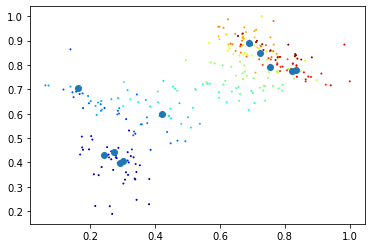

5 18
(287, 4) (287, 2)
[[-1.99368737 -1.18854449  0.05889531 -0.25891476]
 [-1.61270409 -0.57905267  0.2030337  -0.09131859]
 [ 0.55286012  0.55417866  0.75322836  0.24564062]
 [ 0.54458297  1.22944762  0.84822033  0.15210843]
 [ 1.42693138  0.99683691  0.3057152   0.32202032]]


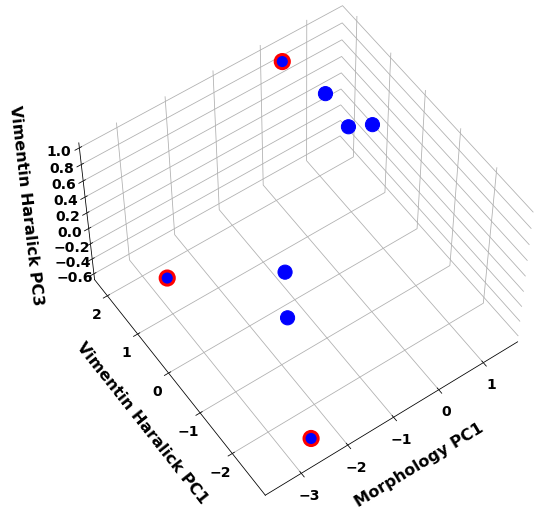

81 83 200 197
(119, 114)
76 80 204 200
(128, 120)
86 76 195 204
(109, 128)
81 65 199 216
(118, 151)
79 70 202 210
(123, 140)
77 90 204 191
(127, 101)
89 79 191 202
(102, 123)
84 81 196 200
(112, 119)
84 88 196 192
(112, 104)
83 90 198 191
(115, 101)
83 79 197 201
(114, 122)
87 70 194 211
(107, 141)
90 71 191 210
(101, 139)
85 75 196 206
(111, 131)
84 77 197 203
(113, 126)
72 81 208 200
(136, 119)
72 80 208 201
(136, 121)
70 72 210 208
(140, 136)
76 74 205 207
(129, 133)
79 73 201 207
(122, 134)
87 72 193 209
(106, 137)
81 69 199 211
(118, 142)
77 74 203 207
(126, 133)
82 74 198 207
(116, 133)
83 75 197 205
(114, 130)
84 71 197 209
(113, 138)
84 72 197 208
(113, 136)
89 74 191 206
(102, 132)
85 65 196 216
(111, 151)
85 77 195 204
(110, 127)
74 83 206 197
(132, 114)
79 84 202 197
(123, 113)
77 85 204 196
(127, 111)
81 81 200 199
(119, 118)
81 75 200 206
(119, 131)
86 75 194 206
(108, 131)
90 69 190 211
(100, 142)
88 78 193 202
(105, 124)
89 84 192 197
(103, 113)
83 82 197 199
(114, 117)


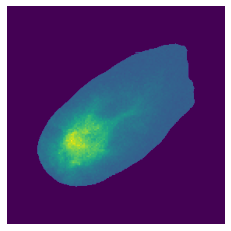

In [20]:
# %matplotlib notebook
# %pylab


all_vim=[]

for i in range(len(sct_list)):
    with open (sct_list[i], 'rb') as fp:
        sct = pickle.load(fp,encoding='iso-8859-1')
    if hasattr(sct,'traj_scale_cord') and hasattr(sct,'traj_vimentin_scale_haralick_pca_cord'):
        if sct.traj_scale_cord is not None:
            print(sct_list[i])
            
            t_start=0
        
            mask=sct.traj_vimentin_feature_values[0]!=0
               
            traj_t=sct.traj_seri[mask][:,0]
            scale_contour,scale_contour_with_vim,scale_haralick,scale_t=sp_traj_scaling(sct)
            
            

#             morph_traj=morph_pc_scaler.transform(sct.traj_scale_cord[mask])
#             vim_traj=vim_pc_scaler.transform(sct.traj_vimentin_scale_haralick_pca_cord[mask])
            morph_traj=(sct.traj_scale_cord[mask]-morph_pc_scaler.mean_)/np.sqrt(morph_pc_scaler.var_)
            vim_traj=(sct.traj_vimentin_scale_haralick_pca_cord[mask]-vim_pc_scaler.mean_)/np.sqrt(vim_pc_scaler.var_)

            X0=np.column_stack((morph_traj,vim_traj))

            
            

            X=np.column_stack((X0[:,0],X0[:,[7,9,10]]))
            X[:,2]=-X[:,2]
            
            print(X.shape,sct.traj_seri[mask].shape)
            
            
            dot_color=np.arange(X.shape[0])/6.0
            cm=plt.cm.get_cmap('jet')

            
            fig = plt.figure(figsize=(12,9))
            ax = fig.add_subplot(111, projection='3d')
            ax.view_init(azim=235, elev=55)
            sel_inds=[36,72,144,180,252]
            sel_inds1=[0,80,216]

            print(X[sel_inds])
#             s3d=ax.scatter3D(X[:,0],X[:,1],X[:,2],c=dot_color,cmap=cm)
            ax.scatter(X[sel_inds,0],X[sel_inds,1],X[sel_inds,2],s=200,alpha=1,color='blue')
    
#                          c=dot_color[sel_inds],cmap=cm)
            ax.scatter(X[sel_inds1,0],X[sel_inds1,1],X[sel_inds1,2],s=200,alpha=1,color='blue',edgecolor='red',linewidth=3)


            plt.xticks(fontsize=14,fontweight='bold')
            plt.yticks(fontsize=14,fontweight='bold')
#             ax.set_zticks([-0.4, 0, 0.4])
            for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(14)
            for t in ax.zaxis.get_major_ticks(): t.label.set_fontweight('bold')

            ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
            ax.set_xlabel('Morphology PC1',fontsize=16,fontweight='bold',labelpad=15)
            ax.set_ylabel('Vimentin Haralick PC1',fontsize=16,fontweight='bold',labelpad=15)
            ax.set_zlabel('Vimentin Haralick PC3',fontsize=16,fontweight='bold',labelpad=15)
#             fig.colorbar(s3d,shrink=0.5,aspect=20)
            plt.savefig(result_path+'cell_state.png',dpi=300)
            plt.show()
            
        
            img_path=input_path+str(posi)+'/'
            img_list=sorted(listdir(img_path))

            fluor_img_path=fluor_input_path+str(posi)+'/'
            fluor_img_list=sorted(listdir(fluor_img_path))

            dir_path=output_path+str(posi)+'/'
            seg_path=dir_path+'seg/' 
            seg_list=sorted(listdir(seg_path))
            
            
#             board_size=200

#             for ind in sel_inds1:
#                 print(ind)
        
#                 img_num=sct.traj_seri[mask][ind,0].astype(np.int)
#                 obj_num=sct.traj_seri[mask][ind,1].astype(np.int)
#                 print(img_num)
#                 if obj_num!=-1:
#                     img=imread(fluor_img_path+fluor_img_list[img_num-1])
#                     seg_img=imread(seg_path+seg_list[img_num-1])
#                     crop_cell,crop_cell_env=generate_single_cell_img(img,seg_img,img_num,obj_num)
#                     x_c,y_c=crop_cell.shape[0]//2,crop_cell.shape[1]//2
#                     x_l,y_l=board_size/2-x_c,board_size/2-y_c
#                     cell_on_board=np.zeros((board_size,board_size))
#                     cell_on_board[x_l:x_l+crop_cell.shape[0],y_l:y_l+crop_cell.shape[1]]=crop_cell

#                     plt.imshow(cell_on_board)
#                     plt.axis('off')
#                     plt.savefig(result_path+'xy'+posi+'_i'+str(img_num)+'_o'+str(obj_num)+'.png',dpi=300)
#                     plt.show()
                    
                    
#             fig=plt.figure()
#             ims=[]
#             for img_num,obj_num in sct.traj_seri[mask]:
#                 img_num=img_num.astype(np.int)
#                 obj_num=obj_num.astype(np.int)
#                 if obj_num!=-1:
#                     img=imread(img_path+img_list[img_num-1])
#                     seg_img=imread(seg_path+seg_list[img_num-1])
#                     crop_cell,crop_cell_env=generate_single_cell_img(img,seg_img,img_num,obj_num)
#                     im=plt.imshow(crop_cell,animated=True)
#                     ims.append([im])
#             ani = animation.ArtistAnimation(fig, ims, interval=150)

#             ani.save(result_path+'sct_'+posi_tl+'long_traj.mp4')
                        
            board_size=280

            fig=plt.figure()
            ims=[]
            for img_num,obj_num in sct.traj_seri[mask]:
                img_num=img_num.astype(np.int)
                obj_num=obj_num.astype(np.int)
                if obj_num!=-1:
                    img=imread(fluor_img_path+fluor_img_list[img_num-1])
                    seg_img=imread(seg_path+seg_list[img_num-1])
                    crop_cell,crop_cell_env=generate_single_cell_img(img,seg_img,img_num,obj_num)
                    x_c,y_c=crop_cell.shape[0]//2,crop_cell.shape[1]//2
                    x_l,y_l=max(0,int(board_size/2-x_c)),max(0,int(board_size/2-y_c))
                    print(x_l,y_l,x_l+crop_cell.shape[0],y_l+crop_cell.shape[1])
                    print(crop_cell.shape)
                    cell_on_board=np.zeros((board_size,board_size))
                    cell_on_board[x_l:x_l+crop_cell.shape[0],y_l:y_l+crop_cell.shape[1]]=crop_cell

                    im=plt.imshow(cell_on_board,animated=True)
                    plt.axis('off')
                    ims.append([im])

            ani = animation.ArtistAnimation(fig, ims, interval=100)
            ani.save(result_path+'sct_'+posi_tl+'long_traj.mp4')


In [6]:
# Y=np.vstack(all_vim)
# ax = plt.axes(projection='3d')
# ax.scatter3D(Y[:,0],Y[:,1],Y[:,2],s=0.01)
# plt.show()

# plt.scatter(Y[:,1],Y[:,2],s=0.01)
# plt.axis('equal')
# plt.show()
# sns.kdeplot(Y[:,1],Y[:,2],n_levels=50,shade=True)
# plt.axis([-1,1,-1,1])
# plt.show()